In [3]:
import pandas as pd
import random
from faker import Faker
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

In [4]:
# Initialize Faker instance
fake = Faker()

# Generate Customer Demographics Data
def generate_customer_demographics(num_customers=1000):
    customer_data = []
    for _ in range(num_customers):
        customer = {
            'customer_id': fake.uuid4(),
            'name': fake.name(),
            'age': random.randint(18, 70),
            'gender': random.choice(['Male', 'Female']),
            'marital_status': random.choice(['Single', 'Married', 'Divorced']),
            'education': random.choice(['High School', 'Bachelor', 'Master', 'PhD']),
            'occupation': fake.job(),
            'salary': random.randint(20000, 150000),  # Yearly salary
        }
        customer_data.append(customer)
    return pd.DataFrame(customer_data)

In [10]:
def generate_financial_behavior(customer_ids, num_records=2000):
    financial_data = []
    for _ in range(num_records):
        product_type = random.choice(['Personal Loan', 'Home Loan', 'Credit Card'])
        loan_amount = random.randint(5000, 500000) if product_type != 'Credit Card' else random.randint(5000, 150000)
        credit_limit = random.randint(1000, 150000) if product_type == 'Credit Card' else None
        utilization = random.uniform(0.1, 1.0) if product_type == 'Credit Card' else None
        max_dpd = random.choice([0, 15, 30, 60, 90, 120])
        default_status = random.choice([True, False])

        financial_behavior = {
            'customer_id': random.choice(customer_ids),
            'product_type': product_type,
            'loan_amount': loan_amount,
            'credit_limit': credit_limit,
            'credit_utilization': utilization,
            'emi_paid': random.randint(1, 24),
            'tenure_months': random.randint(12, 60),
            'max_dpd': max_dpd,
            'default_status': default_status
        }
        financial_data.append(financial_behavior)
    return pd.DataFrame(financial_data)

In [19]:
# Generate Customer Enquiries Data (Last 3 months)
def generate_customer_enquiries(customer_ids, num_records=500):
    enquiries_data = []
    for _ in range(num_records):
        product_type = random.choice(['Personal Loan', 'Home Loan', 'Credit Card'])
        enquiry_amount = random.randint(5000, 500000) if product_type != 'Credit Card' else random.randint(5000, 100000)
        enquiry = {
            'customer_id': random.choice(customer_ids),
            'enquiry_date': fake.date_between(start_date='-90d', end_date='today'),
            'product_type': product_type,
            'enquiry_amount': enquiry_amount,
            'status': random.choice(['Approved', 'Rejected'])
        }
        enquiries_data.append(enquiry)
    return pd.DataFrame(enquiries_data)

In [21]:
# Generate Customer Transaction Data (Past 6 months)
def generate_customer_transactions(customer_ids, num_records=5000):
    transactions_data = []
    for _ in range(num_records):
        transaction_date = fake.date_between(start_date='-180d', end_date='today')
        transaction_amount = random.uniform(50, 10000)
        
        # Transaction description with salary-related and hobby keywords
        transaction_description = random.choice([
            'Salary from XYZ Corp', 'Amazon Purchase', 'Grocery Store', 'Gym Membership',
            'Netflix Subscription', 'Restaurant', 'Fuel Station', 'Travel Booking', 
            'SALARY - ABC Corp', 'SAL credited from DEF Ltd', 'Monthly Salary GHI Pvt Ltd', 
            'Rent Payment', 'Car Insurance', 'Mobile Phone Bill', 'Electricity Bill', 'Spotify Subscription',
            'Uber Ride', 'Etsy Shopping', 'Concert Ticket', 'Books Purchase'
        ])

        # Salary detection
        salary_keywords = ['Salary', 'SALARY', 'SAL', 'SAL credited', 'Monthly Salary']
        is_salary = any(keyword in transaction_description.upper() for keyword in salary_keywords)

        # Hobbies detection based on transaction descriptions
        hobbies = None
        if "Amazon" in transaction_description or "Etsy" in transaction_description:
            hobbies = 'Shopping'
        elif "Netflix" in transaction_description or "Spotify" in transaction_description:
            hobbies = 'Entertainment'
        elif "Gym" in transaction_description:
            hobbies = 'Fitness'
        elif "Concert" in transaction_description:
            hobbies = 'Music'
        elif "Books" in transaction_description:
            hobbies = 'Reading'
        elif "Travel" in transaction_description or "Uber Ride" in transaction_description:
            hobbies = 'Travel'

        transaction = {
            'customer_id': random.choice(customer_ids),
            'transaction_date': transaction_date,
            'transaction_amount': transaction_amount,
            'transaction_description': transaction_description,
            'account_balance': random.uniform(500, 20000),
            'is_salary': is_salary,
            'hobby_detected': hobbies
        }
        transactions_data.append(transaction)

    return pd.DataFrame(transactions_data)

In [24]:
# Generate consistent data across all categories
customers = generate_customer_demographics(5000)
financial_behavior = generate_financial_behavior(customers['customer_id'], num_records=15000)
enquiries = generate_customer_enquiries(customers['customer_id'], num_records=4000)
transactions = generate_customer_transactions(customers['customer_id'], num_records=20000)

In [25]:
merged_df = transactions.merge(customers, on="customer_id", how="left")


In [26]:
merged_df

,customer_id,transaction_date,transaction_amount,transaction_description,account_balance,is_salary,hobby_detected,name,age,gender,marital_status,education,occupation,salary
0,a397d06a-8ca6-42fc-9b9b-0609c7b71dab,2025-04-18,7814.205279,Rent Payment,10447.400431,False,None,Zachary Sullivan,56,Female,Married,Bachelor,Product/process development scientist,132240
1,b4700fcd-7027-4d60-abf5-965b079b611c,2025-04-11,8853.534870,Books Purchase,18085.754283,False,Reading,Jessica Garcia,53,Female,Married,Bachelor,Insurance claims handler,95813
2,17eba362-609a-4a2f-8137-2b7dc13d43c2,2025-06-23,6633.833534,Salary from XYZ Corp,12478.814971,True,None,Nathan Norris Jr.,54,Male,Single,PhD,"Merchandiser, retail",77525
3,270d9468-9559-4701-b522-6afb9b17b02b,2025-04-08,5087.615991,Amazon Purchase,1028.241857,False,Shopping,Ryan Sanchez,38,Male,Single,Bachelor,Information officer,82021
4,99769797-f51c-4401-bc57-6b74cefadb76,2025-06-22,2913.128151,Etsy Shopping,14086.787400,False,Shopping,Joshua Cooper,45,Male,Single,Master,Immigration officer,45313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,e5a4a6c4-cee9-49f2-830e-7963ee3bea94,2025-05-04,9251.169752,Monthly Salary GHI Pvt Ltd,19627.013399,True,None,Kayla Perez,63,Female,Divorced,Bachelor,Theme park manager,38812
19996,e2cc11b4-f7aa-4164-a46c-10e07c942bda,2025-06-22,5121.483639,Restaurant,13540.365451,False,None,Amanda Howard,70,Male,Married,High School,Chartered public finance accountant,21659
19997,8b58d6de-7534-49df-8963-daa263985500,2025-02-06,6920.700569,SAL credited from DEF Ltd,11084.559653,True,None,Timothy Lopez,51,Female,Married,High School,Counsellor,45969
19998,a30a5e3e-53b8-4174-b59a-4ab245175eb6,2025-01-29,2380.462687,Uber Ride,11705.705818,False,Travel,Jessica Marsh,49,Male,Divorced,High School,Orthoptist,25890


In [27]:
# Combine Data for Clustering
# Aggregating financial and transaction data by customer_id to create summary features
financial_summary = financial_behavior.groupby('customer_id').agg({
    'loan_amount': 'mean',
    'credit_limit': 'mean',
    'credit_utilization': 'mean',
    'emi_paid': 'sum',
    'tenure_months': 'mean',
    'max_dpd': 'max',
    'default_status': 'mean',
    'product_type':'unique'
}).reset_index()

In [31]:

financial_summary

,customer_id,loan_amount,credit_limit,credit_utilization,emi_paid,tenure_months,max_dpd,default_status,product_type
0,000cb526-ab7f-4e10-801c-d1dcd2ac5866,198081.500000,50354.5,0.759019,80,31.666667,90,0.500000,"[Credit Card, Personal Loan, Home Loan]"
1,001de677-e7cd-4e12-967d-150a47047604,224765.800000,23411.0,0.913428,51,33.800000,120,0.000000,"[Home Loan, Credit Card, Personal Loan]"
2,0030d275-3630-473a-8c91-6c07c7d01b01,13893.000000,1282.0,0.786332,22,39.000000,90,0.000000,[Credit Card]
3,004128ee-339f-4a23-a46f-515f04c6eab3,239093.500000,112217.0,0.301924,47,49.000000,60,0.000000,"[Personal Loan, Credit Card]"
4,0043a6a6-6992-4a16-af2a-22e5c6a4bc18,189853.666667,111806.0,0.455391,17,32.333333,120,0.666667,"[Credit Card, Personal Loan]"
...,...,...,...,...,...,...,...,...,...
4750,ff9026c7-3624-4694-9d6c-719122e75ab0,61537.000000,105335.0,0.812205,19,40.000000,60,0.500000,"[Credit Card, Personal Loan]"
4751,ff958d1d-2910-4b03-a1b6-49ec686d48a4,179888.333333,NaN,NaN,33,34.000000,120,0.333333,"[Personal Loan, Home Loan]"
4752,ffa6bcf3-73d1-4e00-941f-67c3ea29be28,207311.666667,NaN,NaN,51,43.666667,90,0.666667,"[Personal Loan, Home Loan]"
4753,ffab2f1c-a952-42cc-8762-f7a63a76bfd7,95595.800000,62551.5,0.658343,54,35.400000,120,0.200000,"[Credit Card, Home Loan, Personal Loan]"


In [32]:
transaction_summary = transactions.groupby('customer_id').agg({
    'transaction_amount': 'mean',
    'account_balance': 'mean',
    'is_salary': 'sum',
    'transaction_amount': lambda x: x[transactions['is_salary'] == 1].sum()
}).reset_index()

In [35]:
transaction_summary.head(10)

,customer_id,transaction_amount,account_balance,is_salary
0,000cb526-ab7f-4e10-801c-d1dcd2ac5866,4733.451870,11613.640620,1
1,001de677-e7cd-4e12-967d-150a47047604,8495.138415,10759.571672,1
2,0030d275-3630-473a-8c91-6c07c7d01b01,1647.793081,9543.415972,1
3,004128ee-339f-4a23-a46f-515f04c6eab3,2491.358499,13878.430075,1
4,0043a6a6-6992-4a16-af2a-22e5c6a4bc18,10718.737497,9931.497848,3
5,004553a4-4282-4572-bbd4-39fe5108e001,0.000000,7576.007163,0
6,0053b399-4018-4dd5-8eaf-d140872cecdb,8567.245098,8521.655650,2
7,0082fe83-59fd-445d-b594-cef93806b36c,0.000000,15875.463365,0
8,008bffe6-8f72-4d79-928d-e2aae54665a1,10443.041172,10805.348330,2
9,00b5609e-f054-4536-9533-1aa68ecc14ce,0.000000,10525.194143,0


In [36]:
# Assuming 'enquiries' has columns like ['customer_id', 'product_type', 'enquiry_date', 'enquiry_amount']
enquiries_summary = enquiries.groupby('customer_id').agg({
    'enquiry_amount': 'mean',  # Average amount enquired
    'product_type': lambda x: x.nunique(),  # Number of unique products enquired
    'customer_id': 'count'  # Total number of enquiries
}).rename(columns={
    'customer_id': 'total_enquiries',
    'product_type': 'unique_products_enquired'
}).reset_index()

In [37]:
enquiries_summary

,customer_id,enquiry_amount,unique_products_enquired,total_enquiries
0,001de677-e7cd-4e12-967d-150a47047604,64470.0,1,1
1,0030d275-3630-473a-8c91-6c07c7d01b01,243267.0,1,1
2,004128ee-339f-4a23-a46f-515f04c6eab3,221075.5,1,2
3,00b5609e-f054-4536-9533-1aa68ecc14ce,66822.0,1,1
4,00c6b9e7-8044-40e7-8d0b-048dbe55a64f,144666.0,1,1
...,...,...,...,...
2734,ff83229e-ec3f-4f43-8daa-e99a04b774a1,71835.0,1,1
2735,ff9026c7-3624-4694-9d6c-719122e75ab0,135650.0,1,2
2736,ffa6bcf3-73d1-4e00-941f-67c3ea29be28,485712.0,1,1
2737,ffab2f1c-a952-42cc-8762-f7a63a76bfd7,37792.0,1,1


In [38]:
merged_data = pd.merge(customers, financial_summary, on='customer_id', how='left')
merged_data = pd.merge(merged_data, enquiries_summary, on='customer_id', how='left')
merged_data = pd.merge(merged_data, transaction_summary, on='customer_id', how='left')

In [39]:
merged_data

,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,...,tenure_months,max_dpd,default_status,product_type,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary
0,cbfb65d6-7fcf-43a1-bc2f-17cd0a1117d8,Andre Lamb,19,Male,Single,PhD,Civil Service fast streamer,145680,394166.000000,NaN,...,31.000000,15.0,0.000000,[Personal Loan],244681.00,2.0,2.0,NaN,NaN,NaN
1,45962d4a-27f2-43fa-bf14-b3039b22178c,Bethany Olson,50,Female,Married,Master,Ambulance person,87921,186847.250000,96635.333333,...,22.250000,120.0,0.750000,"[Credit Card, Personal Loan]",80994.50,1.0,2.0,9655.490647,9843.372593,1.0
2,db28acc1-456c-46d6-9dec-37c8ece6d516,Tracy Vargas,36,Male,Married,High School,Set designer,75859,189476.666667,NaN,...,48.000000,90.0,0.666667,"[Home Loan, Personal Loan]",NaN,NaN,NaN,1641.902259,12286.629175,1.0
3,623504bf-5356-4e5a-a435-f65fe52c7501,Jessica Williams,55,Male,Divorced,Master,Armed forces training and education officer,77754,202069.666667,NaN,...,43.000000,120.0,0.333333,"[Personal Loan, Home Loan]",315670.00,1.0,1.0,NaN,NaN,NaN
4,bce67e97-095d-4f88-a609-53f30913b6d1,Tina Lara,31,Male,Married,Master,Ceramics designer,118616,41078.000000,146986.000000,...,57.000000,90.0,1.000000,[Credit Card],60786.00,1.0,1.0,1005.326509,11860.199947,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3420df85-4bac-48fd-87f1-2c2b8b9f8e03,Lonnie Roberts,56,Female,Married,PhD,"Engineer, biomedical",61495,172980.333333,56953.000000,...,36.666667,90.0,0.333333,"[Credit Card, Home Loan]",334823.00,1.0,1.0,0.000000,5309.031145,0.0
4996,c22bdede-90b0-406e-bb80-4b8d63c625ad,Kelly Edwards,60,Female,Married,Master,"Engineer, agricultural",76810,250343.000000,105857.000000,...,39.250000,120.0,0.500000,"[Personal Loan, Credit Card, Home Loan]",NaN,NaN,NaN,0.000000,18487.162423,0.0
4997,f4d5dbff-9c0c-41d6-9f04-e65d3a4978be,Veronica Jones,44,Female,Divorced,High School,Estate agent,62125,165970.500000,70601.000000,...,45.500000,90.0,0.250000,"[Credit Card, Personal Loan, Home Loan]",NaN,NaN,NaN,18481.277744,10146.847842,4.0
4998,948ed5cd-fe89-4f07-b23d-f80d40d592a4,Mark Martinez,31,Male,Single,Bachelor,Warehouse manager,67231,103887.000000,NaN,...,35.000000,90.0,1.000000,[Home Loan],163485.00,1.0,1.0,1057.707988,8519.726668,1.0


In [40]:
# Step 1: Explode the list in 'product_type' column
df_exploded = merged_data.explode('product_type')

# Step 2: One-hot encode the 'product_type' column
df_encoded = pd.get_dummies(df_exploded['product_type'])

merged_data = pd.concat([df_exploded, df_encoded], axis=1)

# Step 4: Group by the original index and aggregate to bring it back into one row per customer
df_final = merged_data.groupby(merged_data.index).sum()
df_final.columns

Index(['customer_id', 'name', 'age', 'gender', 'marital_status', 'education',
       'occupation', 'salary', 'loan_amount', 'credit_limit',
       'credit_utilization', 'emi_paid', 'tenure_months', 'max_dpd',
       'default_status', 'product_type', 'enquiry_amount',
       'unique_products_enquired', 'total_enquiries', 'transaction_amount',
       'account_balance', 'is_salary', 'Credit Card', 'Home Loan',
       'Personal Loan'],
      dtype='object')

In [45]:
# Define the aggregation function for each column
aggregation_functions = {
    'customer_id': 'first',  # Keep first occurrence (assuming it's the same for the group)
    'name': 'first',         # Keep the first name in each group
    'age': 'mean',           # For age, you can take the average or median
    'gender': 'first',       # Assuming gender is the same within each group, take the first
    'marital_status': 'first', # Same for marital status
    'education': 'first',    # Same for education
    'occupation': 'first',   # Same for occupation
    'salary': 'sum',         # Sum numerical values like salary
    'loan_amount': 'sum',    # Sum numerical values like loan amount
    'credit_limit': 'sum',   # Sum numerical values like credit limit
    'credit_utilization': 'sum',
    'emi_paid':'sum',
    'tenure_months':'sum',
    'max_dpd':'max',
    'default_status':'max',
    'enquiry_amount': 'sum',
    'unique_products_enquired': 'sum',
    'total_enquiries': 'sum',
    'transaction_amount': 'sum',
    'account_balance': 'sum',
    'is_salary': 'mean',     # For boolean-like columns, you can take the mean (0 or 1)
    'Credit Card': 'max',    # For categorical (binary) features, take max (0 or 1)
    'Home Loan': 'max',
    'Personal Loan': 'max',
}

# Group by and apply aggregation functions
df_final = merged_data.groupby(merged_data.index).agg(aggregation_functions)
df_final.head()

,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,...,default_status,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary,Credit Card,Home Loan,Personal Loan
0,cbfb65d6-7fcf-43a1-bc2f-17cd0a1117d8,Andre Lamb,19.0,Male,Single,PhD,Civil Service fast streamer,145680,394166.000000,0.000000,...,0.000000,244681.0,2.0,2.0,0.000000,0.000000,NaN,False,False,True
1,45962d4a-27f2-43fa-bf14-b3039b22178c,Bethany Olson,50.0,Female,Married,Master,Ambulance person,175842,373694.500000,193270.666667,...,0.750000,161989.0,2.0,4.0,19310.981293,19686.745186,1.0,True,False,True
2,db28acc1-456c-46d6-9dec-37c8ece6d516,Tracy Vargas,36.0,Male,Married,High School,Set designer,151718,378953.333333,0.000000,...,0.666667,0.0,0.0,0.0,3283.804518,24573.258350,1.0,False,True,True
3,623504bf-5356-4e5a-a435-f65fe52c7501,Jessica Williams,55.0,Male,Divorced,Master,Armed forces training and education officer,155508,404139.333333,0.000000,...,0.333333,631340.0,2.0,2.0,0.000000,0.000000,NaN,False,True,True
4,bce67e97-095d-4f88-a609-53f30913b6d1,Tina Lara,31.0,Male,Married,Master,Ceramics designer,118616,41078.000000,146986.000000,...,1.000000,60786.0,1.0,1.0,1005.326509,11860.199947,1.0,True,False,False


In [46]:
# Drop irrelevant columns for clustering
clustering_data = df_final.drop(columns=['customer_id', 'name', 'occupation','gender','marital_status','education'])
print(clustering_data.columns)


Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary', 'Credit Card',
       'Home Loan', 'Personal Loan'],
      dtype='object')


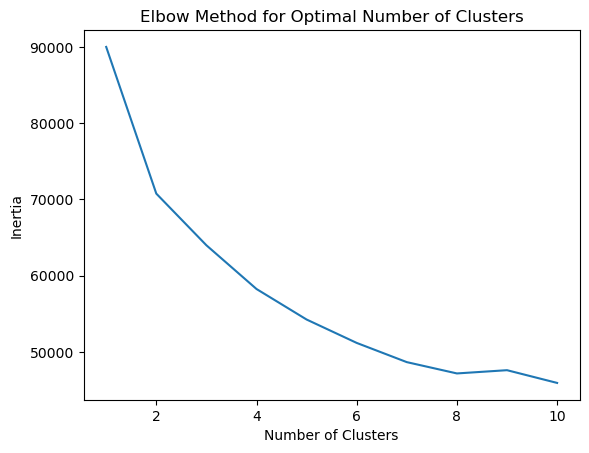

                               customer_id  customer_segment
0     cbfb65d6-7fcf-43a1-bc2f-17cd0a1117d8                 0
1     45962d4a-27f2-43fa-bf14-b3039b22178c                 2
2     db28acc1-456c-46d6-9dec-37c8ece6d516                 0
3     623504bf-5356-4e5a-a435-f65fe52c7501                 0
4     bce67e97-095d-4f88-a609-53f30913b6d1                 2
...                                    ...               ...
4995  3420df85-4bac-48fd-87f1-2c2b8b9f8e03                 2
4996  c22bdede-90b0-406e-bb80-4b8d63c625ad                 1
4997  f4d5dbff-9c0c-41d6-9f04-e65d3a4978be                 1
4998  948ed5cd-fe89-4f07-b23d-f80d40d592a4                 0
4999  17eba402-294f-4955-8599-5bf584e417a1                 1

[5000 rows x 2 columns]


In [48]:
# Handle missing values
clustering_data.fillna(0, inplace=True)
# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Determine optimal number of clusters (elbow method)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal K (say K=4 based on the elbow curve)
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['customer_segment'] = kmeans.fit_predict(scaled_data)

# View segmented data
print(df_final[['customer_id', 'customer_segment']])

In [51]:
pd.set_option('display.max_columns', None)
# Assuming df_final is your DataFrame and 'customer_segment' is the column to group by
float_columns = df_final.select_dtypes(include=['int','float'])
grouped_df = float_columns.groupby('customer_segment')

# Summary of each segment
segment_description = grouped_df.describe()
segment_description

age                                                      \
                   count       mean        std   min   25%   50%   75%   max   
customer_segment                                                               
0                 1834.0  43.872955  15.379849  18.0  31.0  44.0  57.0  70.0   
1                 1273.0  43.976434  15.101108  18.0  31.0  44.0  57.0  70.0   
2                 1893.0  43.401479  15.276432  18.0  30.0  43.0  57.0  70.0   

                  salary                                                   \
                   count           mean            std      min       25%   
customer_segment                                                            
0                 1834.0  119435.084515   68421.288909  20004.0   68662.5   
1                 1273.0  257292.346426  109310.445256  60168.0  166176.0   
2                 1893.0  147646.153724   75616.332870  20139.0   85255.0   

                                               loan_amount                 \
                       50%       75%       max       count           mean   
customer_segment                                                            
0                 108176.5  144555.5  299498.0      1834.0  312748.047021   
1                 257973.0  350904.0  449922.0      1273.0  574676.948208   
2                 133072.0  210048.0  404985.0      1893.0  269625.989874   

                                                                    \
                            std       min       25%            50%   
customer_segment                                                     
0                 218904.500976      0.00  135411.5  304232.333333   
1                 179638.662838  98453.25  450043.5  567792.000000   
2                 157094.543687   7164.00  128998.0  268522.000000   

                                           credit_limit                 \
                         75%           max        count           mean   
customer_segment                                                         
0                 466321.375  9.759750e+05       1834.0       0.000000   
1                 689394.500  1.196803e+06       1273.0  218823.078921   
2                 385711.500  6.889873e+05       1893.0  129928.955503   

                                                                       \
                            std     min       25%       50%       75%   
customer_segment                                                        
0                      0.000000     0.0       0.0       0.0       0.0   
1                 114204.494956     0.0  135794.0  219788.0  300472.5   
2                  76203.875915  1282.0   69190.5  122630.0  183343.5   

                           credit_utilization                                \
                       max              count      mean       std       min   
customer_segment                                                              
0                      0.0             1834.0  0.000000  0.000000  0.000000   
1                 449547.0             1273.0  1.595397  0.685129  0.000000   
2                 327699.0             1893.0  0.973983  0.484018  0.109864   

                                                         emi_paid              \
                       25%       50%       75%       max    count        mean   
customer_segment                                                                
0                 0.000000  0.000000  0.000000  0.000000   1834.0   39.833697   
1                 1.041541  1.597983  2.122410  2.996404   1273.0  180.349568   
2                 0.589410  0.917814  1.347666  2.957308   1893.0   64.982567   

                                                              tenure_months  \
                        std   min    25%    50%    75%    max         count   
customer_segment                                                              
0                 39.436375   0.0    9.0   25.0   64.0  232.0        1834.0   
1                 71.293802  22

In [52]:
# Preparing data for regression model (predicting loan amount)
# Drop non-numerical and unnecessary columns for regression
regression_data = df_final.drop(columns=['customer_id', 'name', 'occupation','gender','marital_status','education'])
regression_data.fillna(-888, inplace=True)

# Define models for each product type
rf_regressor_personal_loan = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_home_loan = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_credit_card = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model for Personal Loan
X_personal_loan = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 1)].drop(columns=['loan_amount'])
y_personal_loan = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 1)]['loan_amount']
X_train_personal_loan, X_test_personal_loan, y_train_personal_loan, y_test_personal_loan = train_test_split(X_personal_loan, y_personal_loan, test_size=0.2, random_state=42)
rf_regressor_personal_loan.fit(X_personal_loan, y_personal_loan)

# Train the model for Home Loan
X_home_loan = regression_data[(regression_data['Home Loan'] == 1) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 0)].drop(columns=['loan_amount'])
y_home_loan = regression_data[(regression_data['Home Loan'] == 1) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 0)]['loan_amount']
X_train_home_loan, X_test_home_loan, y_train_home_loan, y_test_home_loan = train_test_split(X_home_loan, y_home_loan, test_size=0.2, random_state=42)
rf_regressor_home_loan.fit(X_train_home_loan, y_train_home_loan)

# Train the model for Credit Card
X_credit_card = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 1) & (regression_data['Personal Loan']== 0)].drop(columns=['loan_amount'])
y_credit_card = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 1) & (regression_data['Personal Loan']== 0)]['loan_amount']
X_train_credit_card, X_test_credit_card, y_train_credit_card, y_test_credit_card = train_test_split(X_credit_card, y_credit_card, test_size=0.2, random_state=42)
rf_regressor_credit_card.fit(X_train_credit_card, y_train_credit_card)

# Predict on test set
y_pred = rf_regressor_credit_card.predict(X_test_credit_card)

# Evaluate the model
mse = mean_squared_error(y_test_credit_card, y_pred)
print(f"Mean Squared Error: {mse}")

# Example: Making predictions for a new customer
new_customer_data = X_test_credit_card.iloc[0:1]  # Select one customer data for testing
predicted_loan_amount = rf_regressor_credit_card.predict(new_customer_data)
print(f"Predicted Loan Amount: {predicted_loan_amount[0]}")

Mean Squared Error: 1510016811.4932823
Predicted Loan Amount: 69561.99833333334


In [53]:
classification_data = df_final.copy()
classification_data.fillna(-888, inplace=True)
# Step 2: Drop unnecessary columns for the model and target columns
X_classification = classification_data.drop(columns=['customer_id', 'name', 'occupation', 'gender', 
                                                   'marital_status', 'education', 'Credit Card', 'Home Loan', 'Personal Loan'])
y_classification = classification_data[['Credit Card', 'Home Loan', 'Personal Loan']]  # Multi-output target columns

# Step 3: Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Step 4: Initialize Random Forest Classifier with MultiOutputClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier = MultiOutputClassifier(rf_classifier)

# Step 5: Train the model on the training data for all three outputs
multi_target_classifier.fit(X_train_class, y_train_class)

# Step 6: Predict probabilities for the test set
y_prob_test = [estimator.predict_proba(X_test_class)[:, 1] for estimator in multi_target_classifier.estimators_]

# Combine probabilities into a DataFrame for easier handling
probabilities = pd.DataFrame({
    'Credit Card': y_prob_test[0],   # Probability for Credit Card
    'Home Loan': y_prob_test[1],     # Probability for Home Loan
    'Personal Loan': y_prob_test[2]  # Probability for Personal Loan
})

# Step 7: Find the most probable product for each customer
most_probable_product = probabilities.idxmax(axis=1)

# Optional: Evaluate model performance
y_pred = multi_target_classifier.predict(X_test_class)
print("\nClassification Report for Credit Card:")
print(classification_report(y_test_class['Credit Card'], y_pred[:, 0]))

print("\nClassification Report for Home Loan:")
print(classification_report(y_test_class['Home Loan'], y_pred[:, 1]))

print("\nClassification Report for Personal Loan:")
print(classification_report(y_test_class['Personal Loan'], y_pred[:, 2]))


Classification Report for Credit Card:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       358
        True       1.00      1.00      1.00       642

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Classification Report for Home Loan:
              precision    recall  f1-score   support

       False       0.65      0.73      0.69       335
        True       0.86      0.80      0.83       665

    accuracy                           0.78      1000
   macro avg       0.75      0.77      0.76      1000
weighted avg       0.79      0.78      0.78      1000


Classification Report for Personal Loan:
              precision    recall  f1-score   support

       False       0.71      0.63      0.67       385
        True       0.78      0.84      0.81       615

    accuracy                           0.76      1000
   macro

In [59]:
import joblib

# Define the file paths for saving
model_paths = {
    'kmeans': 'models/kmeans_model.pkl',
    'scaler': 'models/scaler.pkl',
    'multi_target_classifier': 'models/multi_target_classifier_model.pkl',
    'rf_regressor_personal_loan': 'models/rf_regressor_personal_loan_model.pkl',
    'rf_regressor_home_loan': 'models/rf_regressor_home_loan_model.pkl',
    'rf_regressor_credit_card': 'models/rf_regressor_credit_card_model.pkl'
}

# Save models to disk
joblib.dump(kmeans, model_paths['kmeans'])
joblib.dump(scaler, model_paths['scaler'])
joblib.dump(multi_target_classifier, model_paths['multi_target_classifier'])
joblib.dump(rf_regressor_personal_loan, model_paths['rf_regressor_personal_loan'])
joblib.dump(rf_regressor_home_loan, model_paths['rf_regressor_home_loan'])
joblib.dump(rf_regressor_credit_card, model_paths['rf_regressor_credit_card'])

print("Models saved successfully!")

Models saved successfully!


In [64]:
model_paths = {
    'kmeans': 'models/kmeans_model.pkl',
    'scaler': 'models/scaler.pkl',
    'multi_target_classifier': 'models/multi_target_classifier_model.pkl',
    'rf_regressor_personal_loan': 'models/rf_regressor_personal_loan_model.pkl',
    'rf_regressor_home_loan': 'models/rf_regressor_home_loan_model.pkl',
    'rf_regressor_credit_card': 'models/rf_regressor_credit_card_model.pkl'
}

kmeans = joblib.load(model_paths['kmeans'])
scaler = joblib.load(model_paths['scaler'])
multi_target_classifier = joblib.load(model_paths['multi_target_classifier'])
rf_regressor_personal_loan = joblib.load(model_paths['rf_regressor_personal_loan'])
rf_regressor_home_loan = joblib.load(model_paths['rf_regressor_home_loan'])
rf_regressor_credit_card = joblib.load(model_paths['rf_regressor_credit_card'])

print("Models loaded successfully!")


def process_customer_data(json_data, scaler):
    # Convert JSON data to a DataFrame
    customer_data = pd.DataFrame([json_data])
    
    # Drop columns not needed for clustering (based on your clustering model)
    clustering_data = customer_data
    
    # Handle missing values by replacing with 0 (or any appropriate strategy)
    clustering_data.fillna(0, inplace=True)
    
    scaled_data = scaler.transform(clustering_data)
    
    return customer_data, scaled_data

def predict_customer_segment(scaled_data, kmeans):
    # Predict the customer segment using your pre-trained KMeans model
    customer_segment = kmeans.predict(scaled_data)
    return customer_segment[0]

def recommend_product_and_loan(json_data, kmeans, scaler, multi_target_classifier, rf_regressor_personal_loan, rf_regressor_home_loan, rf_regressor_credit_card):
    # Convert JSON data to a DataFrame and scale the data
    customer_data, scaled_data = process_customer_data(json_data, scaler)

    # Step 1: Predict customer segment using KMeans
    customer_segment = predict_customer_segment(scaled_data, kmeans)
    
    # Add the predicted customer segment back to the customer_data DataFrame
    customer_data['customer_segment'] = customer_segment
    print(customer_data.columns)
    # Prepare for product recommendation using Random Forest Classifier
    X_classification_prod = customer_data.drop(columns=['Credit Card', 'Home Loan', 'Personal Loan'])
    X_classification_amt = customer_data
    
    # Step 2: Predict probabilities for each product using the multi-output classifier
    prob_credit_card = [estimator.predict_proba(X_classification_prod)[:, 1] for estimator in multi_target_classifier.estimators_]

    # Combine probabilities into a Series
    product_probabilities = pd.Series({
        'Credit Card': prob_credit_card[0][0],  # Since it's for one customer, we get the first value
        'Home Loan': prob_credit_card[1][0],
        'Personal Loan': prob_credit_card[2][0]
    })

    print(product_probabilities)
    
    # Identify the most probable product
    recommended_product = product_probabilities.idxmax()    
    recommended_probability = product_probabilities.max()

    recommendation = f"Recommended Product: {recommended_product} (Probability: {recommended_probability:.2f})"

    # Step 3: Predict loan amounts or credit limits based on the recommended product
    if recommended_product == 'Personal Loan':
        predicted_loan_amount_personal = rf_regressor_personal_loan.predict(X_classification_amt.drop(columns=['loan_amount']))
        recommendation += f"\nPredicted Loan Amount: {predicted_loan_amount_personal[0]:,.2f}"
    
    elif recommended_product == 'Home Loan':
        predicted_loan_amount_home = rf_regressor_home_loan.predict(X_classification_amt.drop(columns=['loan_amount']))  
        recommendation += f"\nPredicted Loan Amount: {predicted_loan_amount_home[0]:,.2f}"
    
    elif recommended_product == 'Credit Card':
        predicted_credit_limit = rf_regressor_credit_card.predict(X_classification_amt.drop(columns=['loan_amount']))
        recommendation += f"\nPredicted Credit Limit: {predicted_credit_limit[0]:,.2f}"
    
    if recommended_probability < 0.5:
        recommendation = "No suitable product recommendations found for this customer."
    
    return recommendation, customer_segment, product_probabilities

# Example customer JSON data
example_json = {
    'age': 35, 'salary': 50000, 'loan_amount': 0, 'credit_limit': 10000, 
    'credit_utilization': 0.3, 'emi_paid': 1000, 'tenure_months': 12, 
    'max_dpd': 30, 'default_status': 0, 'enquiry_amount': 1000, 
    'unique_products_enquired': 3, 'total_enquiries': 5, 
    'transaction_amount': 5000, 'account_balance': 15000, 'is_salary': 1,
    'Credit Card': 1, 'Home Loan': 0, 'Personal Loan': 0, 
}

# Example usage:
recommend_product_and_loan(example_json, kmeans, scaler, multi_target_classifier, rf_regressor_personal_loan, rf_regressor_home_loan, rf_regressor_credit_card)

Models loaded successfully!
Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary', 'Credit Card',
       'Home Loan', 'Personal Loan', 'customer_segment'],
      dtype='object')
Credit Card      0.96
Home Loan        0.47
Personal Loan    0.42
dtype: float64


('Recommended Product: Credit Card (Probability: 0.96)\nPredicted Credit Limit: 62,760.74',
 1,
 Credit Card      0.96
 Home Loan        0.47
 Personal Loan    0.42
 dtype: float64)

In [73]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain.llms import HuggingFacePipeline
from functools import lru_cache

@lru_cache(maxsize=None)
def load_model():
    model_name = "KingNish/Qwen2.5-0.5b-Test-ft"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    return tokenizer, model

# Function to generate insights based on customer data
# Function to generate insights based on customer data
def generate_insights(customer_data):
    tokenizer, model = load_model()

    # Create a prompt from the customer data
    prompt = f"""
    Generate a personalized summarised insight about the following customer based on their data:
    
    - Name: {customer_data['name']}
    - Age: {customer_data['age']}
    - Gender: {customer_data['gender']}
    - Marital Status: {customer_data['marital_status']}
    - Education: {customer_data['education']}
    - Occupation: {customer_data['occupation']}
    - Salary: ${customer_data['salary']:,.2f}
    - Loan Amount: ${customer_data['loan_amount']:,.2f}
    - Product Type: {customer_data['product_type']}
    - Credit Limit: ${customer_data['credit_limit']:,.2f}
    - Credit Utilization: {customer_data['credit_utilization']:.2%}
    - EMI Paid: {customer_data['emi_paid']}
    - Tenure Months: {round(float(customer_data['tenure_months']),2)}
    - Max DPD: {customer_data['max_dpd']}
    - Default Status: {int(customer_data['default_status'])}
    - Account Balance: ${customer_data['account_balance']:,.2f}

    Here are the Summarised Insights about {customer_data['name']}:
    """
    # Initialize the query pipeline with increased max_length
    query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        max_length=6000,  # Increase max_length
        max_new_tokens=500,  # Control the number of new tokens generated
        device_map="auto",
    )

    llm = HuggingFacePipeline(pipeline=query_pipeline)

    insights = llm(prompt)
    return insights

In [74]:
import pandas as pd
import json

def df_row_to_json(row):
    data = row.to_dict()
    for key, value in data.items():
        if pd.isnull(value):
            data[key] = None
        elif isinstance(value, pd.Timestamp):
            data[key] = value.isoformat()

    # Convert to JSON string
    json_str = json.dumps(data, indent=4)
    return json_str

# Assuming `merged_data` is a DataFrame and we're converting row 8 to JSON
json_data_str = df_row_to_json(df_final.iloc[6])

# Now convert the JSON string back to a dictionary to access fields
json_data_dict = json.loads(json_data_str)

# insights = generate_insights(json_data_dict)
print(json_data_str)
pd.DataFrame.from_dict(json_data_dict, orient='index').T

{
    "customer_id": "5631a716-184a-4ed4-a8d1-6e671a4497a2",
    "name": "Justin Porter",
    "age": 28.0,
    "gender": "Female",
    "marital_status": "Married",
    "education": "PhD",
    "occupation": "Civil Service administrator",
    "salary": 20139,
    "loan_amount": 81006.0,
    "credit_limit": 57152.0,
    "credit_utilization": 0.10986414867354735,
    "emi_paid": 19.0,
    "tenure_months": 33.0,
    "max_dpd": 90.0,
    "default_status": 1.0,
    "enquiry_amount": 89170.0,
    "unique_products_enquired": 1.0,
    "total_enquiries": 1.0,
    "transaction_amount": 5076.61013279576,
    "account_balance": 7226.5253323894685,
    "is_salary": 1.0,
    "Credit Card": true,
    "Home Loan": false,
    "Personal Loan": false,
    "customer_segment": 2
}


,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,credit_utilization,emi_paid,tenure_months,max_dpd,default_status,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary,Credit Card,Home Loan,Personal Loan,customer_segment
0,5631a716-184a-4ed4-a8d1-6e671a4497a2,Justin Porter,28.0,Female,Married,PhD,Civil Service administrator,20139,81006.0,57152.0,0.109864,19.0,33.0,90.0,1.0,89170.0,1.0,1.0,5076.610133,7226.525332,1.0,True,False,False,2
